# Image-Based Airbnb Pricing Algorithm
- Created a deep learning alogrithm to predict the price of an Airbnb listing only from a picture from the listing
- used two types of CNN's models
    1. a custom CNN 
    2. InceptionV3 that was pre-trained on the image_net dataset    
- Data: downloaded a csv with Airbnb data from http://insideairbnb.com/get-the-data.html 
    - only used data from Sinapore


### Setup Google Colab

In [12]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Understanding / Cleaning the data

In [0]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import *


from PIL import Image
import requests
from io import BytesIO

In [0]:
# download the data and make the price column into floats instead of strings
Airbnb_data = pd.read_csv('/content/drive/My Drive/Airbnb_Project/listings_final.csv')
# Airbnb_data['price'] = Airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)

#### Select Data

In [0]:
# select all listings where the price is greater than 20, less than 500
My_data = Airbnb_data[Airbnb_data['bedrooms'] == 3]

In [0]:
My_data = My_data.reset_index()
My_data = My_data.drop('index', axis = 1)

## Preparing the data for trainig

In [0]:
Image_data = My_data.copy
# Image_data = Image_data.reset_index()

In [0]:
# view one of the images
from PIL import Image
import requests
from io import BytesIO

In [0]:
# gets a list of the images as well as the prices
def get_img(m):
  img_list = []
  price_list = []
  data_dict=()
  i = 0
  while i<m: # range(len(data['price']))
    try:
      if i % 100 == 0:
        print(int((i/m*100)),'% done')  # Just to print the status bar in a rough manner.
      response = requests.get(My_data['picture_url'][i])
      img = Image.open(BytesIO(response.content)).resize([224,224])
      img = np.array(img) / 255.0 # makes inputs [0,1]
      img_list.append(img)
      price_list.append(My_data.price[i])
    except:
      print("There is some error getting the url ",i)
      i+=1
      m+=1
      continue
    i+=1
  return img_list, price_list

0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
1000
1000


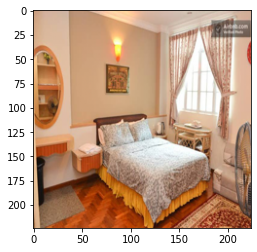

In [24]:
X, y = get_img(1000)
X = np.asarray(X)
y = np.asarray(y)
print(len(X))
print(len(y))
#sanity check one plot
plt.imshow(X[0])

In [25]:
print(len(X))
print(len(y))

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = y.max()

print(maxPrice)

1000
1000
6.270988432


In [26]:
print("X.shape",X.shape)

X.shape (1000, 224, 224, 3)


In [27]:
My_data1000 = My_data.loc[0:999]
print(len(My_data1000))
My_data1000 = My_data1000.drop(columns = ['picture_url', 'price'])

1000


In [0]:
# split up the training set and test set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size =  0.20, random_state = 42)
X_trainfeature,X_testfeature, y_train, y_test = train_test_split(My_data1000, y, test_size =  0.20, random_state = 42)

In [0]:
# data normalization with sklearn
def scale_input(train,test):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train)
    # apply transform
    normalized_train = scaler.transform(train)
    normalized_test = scaler.transform(test)
    return normalized_train, normalized_test
    
X_trainfeatureScale,X_testfeatureScale = scale_input(X_trainfeature,X_testfeature)

In [0]:
print(len(X_train))
print(len(X_test))
print(len(X_trainfeature))
print(len(X_testfeature))

800
200
800
200


In [0]:
!pip install Keras

## Model

In [0]:
from sklearn.metrics import mean_squared_error as skmse
from sklearn.metrics import r2_score as skr2
from sklearn.metrics import mean_absolute_error as skmae
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPool2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.layers import AveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, AveragePooling2D
import math
from sklearn.preprocessing import StandardScaler as stdscl

from keras.utils import plot_model

### 1. Custom CNN
####  1.1 Initial CNN Model with Image Features Only.

In [0]:
# from tensorflow import keras

model = Sequential()
model.add(Conv2D(32, kernel_size=3,strides=2, activation='relu',padding='SAME', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='VALID'))
model.add(Conv2D(64, kernel_size=3,strides=1, activation='relu',padding='SAME'))
model.add(AveragePooling2D(pool_size=(3,3),strides=1,padding='VALID'))
model.add(Conv2D(128, kernel_size=3,strides=2, activation='relu',padding='SAME'))
model.add(Dropout(.5))
model.add(Conv2D(64, kernel_size=3,strides=1, activation='relu',padding='SAME'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(.25))
model.add(Dense(31,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 128)       73856     
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 27, 64)       

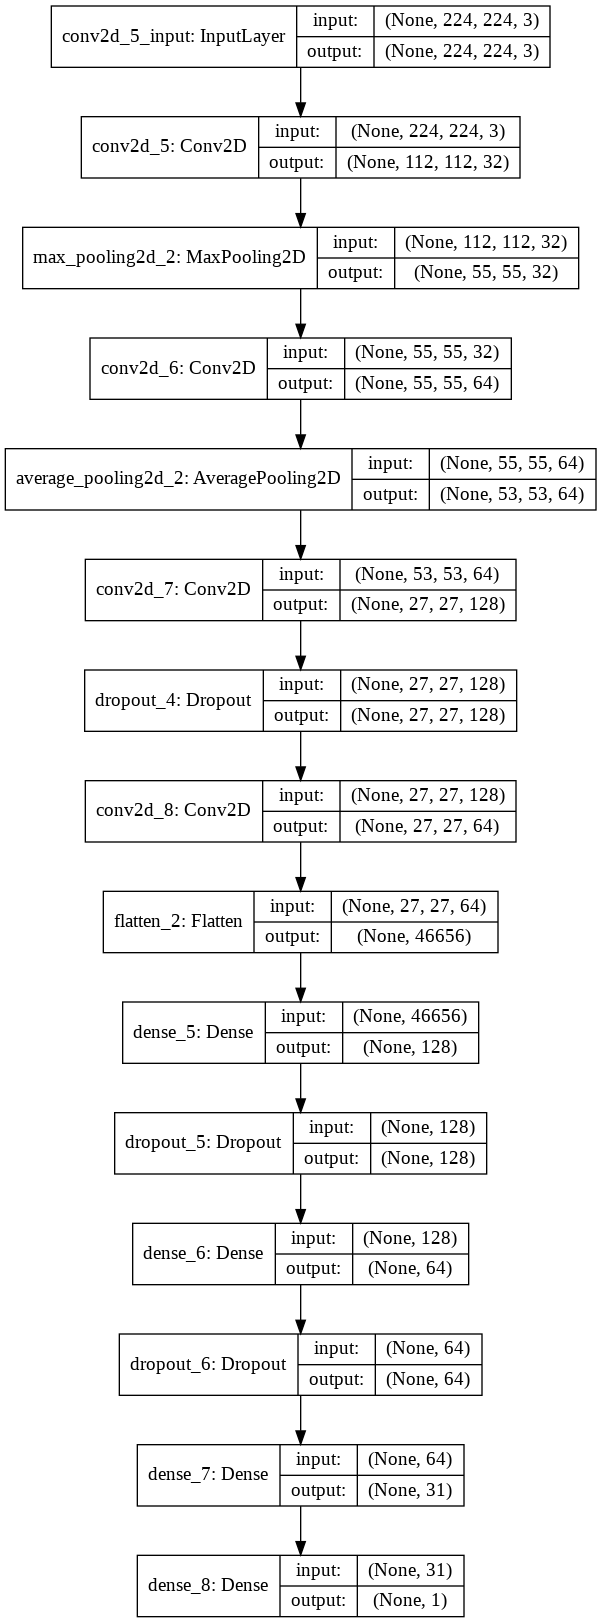

In [0]:
model.summary()
plot_model(model,show_shapes=True,to_file='model_initialCNN.png')

In [65]:
# trains the model without y scaling
history = model.fit(X_train, y_train, epochs=30,validation_split = 0.2,batch_size=5)  # 20% validation data

CNN_pred = model.predict(X_test)
CNN_mse = skmse(y_test, CNN_pred)
CNN_mae = skmae(y_test, CNN_pred)
CNN_r2 = skr2(y_test, CNN_pred)
print("CNN alone, MSE = ", CNN_mse)
print("CNN alone, MAE = ", CNN_mae)
print("CNN alone, R2 = ", CNN_r2)

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 2s 3ms/step - loss: 5.1801 - mse: 5.1801 - mae: 1.8075 - val_loss: 2.0999 - val_mse: 2.0999 - val_mae: 1.3768
Epoch 2/30
640/640 [==============================] - 2s 2ms/step - loss: 1.7711 - mse: 1.7711 - mae: 1.0808 - val_loss: 3.5280 - val_mse: 3.5280 - val_mae: 1.8257
Epoch 3/30
640/640 [==============================] - 1s 2ms/step - loss: 1.2458 - mse: 1.2458 - mae: 0.8940 - val_loss: 4.6475 - val_mse: 4.6475 - val_mae: 2.1088
Epoch 4/30
640/640 [==============================] - 1s 2ms/step - loss: 1.1538 - mse: 1.1538 - mae: 0.8445 - val_loss: 5.8110 - val_mse: 5.8110 - val_mae: 2.3689
Epoch 5/30
640/640 [==============================] - 1s 2ms/step - loss: 0.9956 - mse: 0.9956 - mae: 0.7651 - val_loss: 5.9855 - val_mse: 5.9855 - val_mae: 2.4053
Epoch 6/30
640/640 [==============================] - 1s 2ms/step - loss: 0.9760 - mse: 0.9760 - mae: 0.7729 - val_loss: 6.6732 - val_

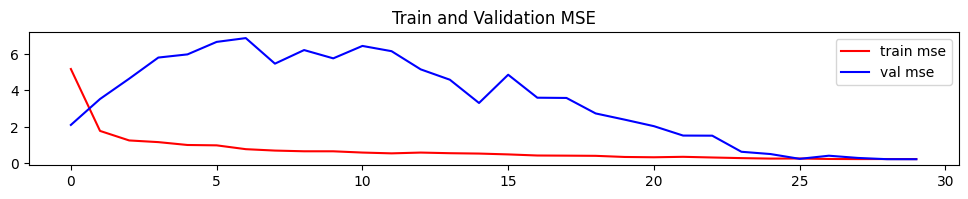

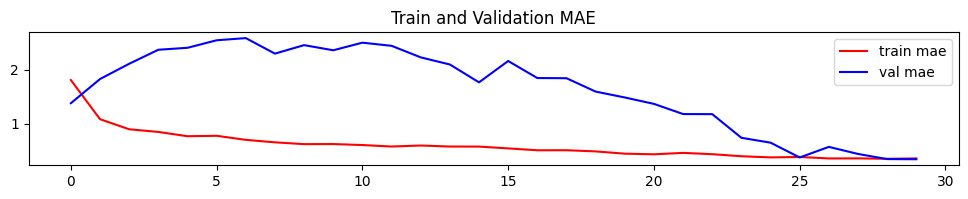

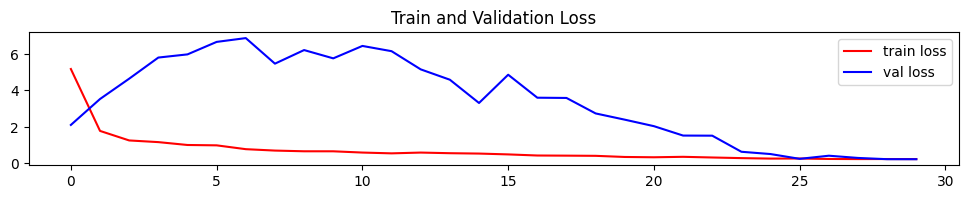

In [66]:
def history_plot():
  mse = history.history['mse']
  val_mse = history.history['val_mse']

  mae = history.history['mae']
  val_mae = history.history['val_mae']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epoch_number = range(len(mse))
  import matplotlib.pyplot as plt

  %matplotlib inline
  plt.figure(figsize=(12, 6), dpi=100)
  plt.subplot(3,1,1)
  plt.plot(epoch_number, mse, 'r', label='train mse')
  plt.plot(epoch_number, val_mse, 'b', label='val mse')
  plt.title('Train and Validation MSE')
  plt.legend()

  plt.figure(figsize=(12, 6), dpi=100)
  plt.subplot(3,1,2)
  plt.plot(epoch_number, mae, 'r', label='train mae')
  plt.plot(epoch_number, val_mae, 'b', label='val mae')
  plt.title('Train and Validation MAE')
  plt.legend()

  plt.figure(figsize=(12, 6), dpi=100)
  plt.subplot(3,1,3)
  plt.plot(epoch_number, loss, 'r', label='train loss')
  plt.plot(epoch_number, val_loss, 'b', label='val loss')
  plt.title('Train and Validation Loss')
  plt.legend()

history_plot() 

In [67]:
# trains the model with y scaling
history = model.fit(X_train, y_train/maxPrice, epochs=30,validation_split = 0.2,batch_size=5)  # 20% validation data

CNN_pred_scale = model.predict(X_test)
CNN_mse = skmse(y_test, CNN_pred_scale*maxPrice)
CNN_mae = skmae(y_test, CNN_pred_scale*maxPrice)
CNN_r2 = skr2(y_test, CNN_pred_scale*maxPrice)
print("CNN alone, MSE = ", CNN_mse)
print("CNN alone, MAE = ", CNN_mae)
print("CNN alone, R2 = ", CNN_r2)

Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 2s 2ms/step - loss: 1.5524 - mse: 1.5524 - mae: 0.6163 - val_loss: 0.0063 - val_mse: 0.0063 - val_mae: 0.0626
Epoch 2/30
640/640 [==============================] - 1s 2ms/step - loss: 0.0203 - mse: 0.0203 - mae: 0.1119 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0590
Epoch 3/30
640/640 [==============================] - 1s 2ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.1066 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0543
Epoch 4/30
640/640 [==============================] - 2s 2ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0982 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0526
Epoch 5/30
640/640 [==============================] - 1s 2ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.1027 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0496
Epoch 6/30
640/640 [==============================] - 1s 2ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0972 - val_loss: 0.0051 - val_

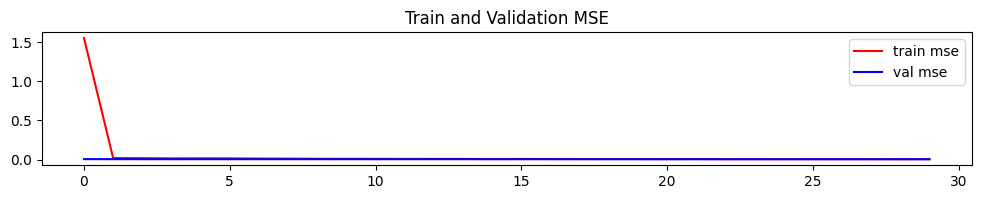

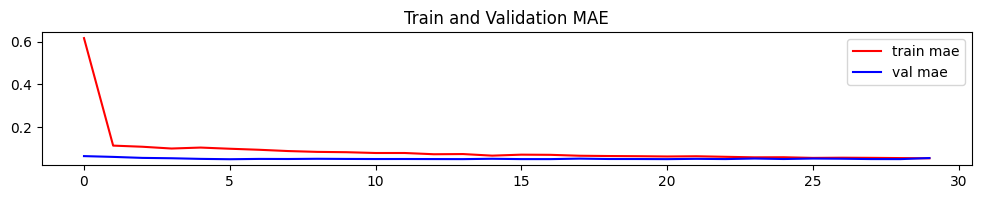

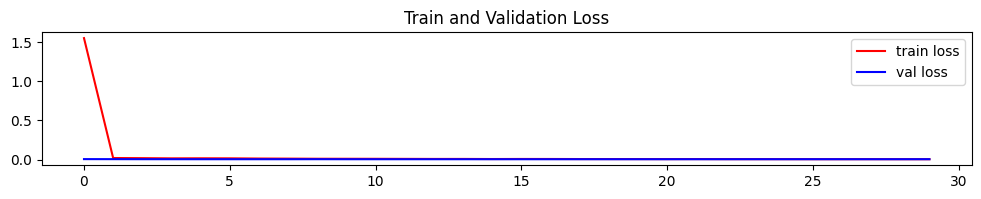

In [68]:
history_plot() 

#### 1.2 CNN Model with Image and Other Features



In [0]:
def create_mlp(dim, regress=False):# define our MLP network
  model = Sequential()
  model.add(Dense(80, input_dim=dim, activation="relu"))
  model.add(Dense(50, activation = 'relu'))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(10, activation="relu"))
  model.add(Dense(4, activation="linear"))
  model.add(Dense(4, activation="linear"))

	# check to see if the regression node should be added
  if regress:
    model.add(Dense(1, activation="linear"))

	# return our model
  return model

def create_cnn(dim, regress=False):
  # initialize the input shape and channel dimension, assuming
  # TensorFlow/channels-last ordering
  inputShape = dim
  # define the model input
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3,strides=2, activation='relu',padding='SAME', input_shape=(224, 224, 3)))
  model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='VALID'))
  model.add(Conv2D(64, kernel_size=3,strides=1, activation='relu',padding='SAME'))
  model.add(AveragePooling2D(pool_size=(3,3),strides=1,padding='VALID'))
  model.add(Conv2D(128, kernel_size=3,strides=2, activation='relu',padding='SAME'))
  model.add(Dropout(.5))
  model.add(Conv2D(64, kernel_size=3,strides=1, activation='relu',padding='SAME'))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(.5))
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(.25))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(.125))
  model.add(Dense(16,activation='relu'))
  model.add(Dropout(.0625))
  model.add(Dense(8,activation='relu'))
  model.add(Dropout(.03125))
  model.add(Dense(4,activation='relu'))
  if regress:
    model.add(Dense(1, activation="linear"))
  return model

In [70]:
from keras.optimizers import Adam
import locale

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
print("[INFO] processing data...")
trainImagesX, testImagesX, trainy, testy = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# using scaled features
trainAttrX, testAttrX, trainy, testy = train_test_split(X_trainfeatureScale, y_train, test_size=0.20, random_state=42)

# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(X[0].shape, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer=opt, loss='mse', metrics=['mse','mae'])

# train the model
print("[INFO] training model...")
history = model.fit(
	[trainAttrX, trainImagesX], trainy,
	validation_data=([testAttrX, testImagesX], testy),
	epochs=30, batch_size=5)

[INFO] processing data...
[INFO] training model...
Train on 640 samples, validate on 160 samples
Epoch 1/30
640/640 [==============================] - 2s 4ms/step - loss: 6.6535 - mse: 6.6535 - mae: 2.0257 - val_loss: 1.3056 - val_mse: 1.3056 - val_mae: 1.0338
Epoch 2/30
640/640 [==============================] - 2s 3ms/step - loss: 0.9249 - mse: 0.9249 - mae: 0.7144 - val_loss: 0.4884 - val_mse: 0.4884 - val_mae: 0.5725
Epoch 3/30
640/640 [==============================] - 2s 3ms/step - loss: 0.4790 - mse: 0.4790 - mae: 0.5270 - val_loss: 0.2024 - val_mse: 0.2024 - val_mae: 0.3401
Epoch 4/30
640/640 [==============================] - 2s 3ms/step - loss: 0.2506 - mse: 0.2506 - mae: 0.3689 - val_loss: 0.1919 - val_mse: 0.1919 - val_mae: 0.3473
Epoch 5/30
640/640 [==============================] - 2s 3ms/step - loss: 0.1746 - mse: 0.1746 - mae: 0.3175 - val_loss: 0.1300 - val_mse: 0.1300 - val_mae: 0.2811
Epoch 6/30
640/640 [==============================] - 2s 3ms/step - loss: 0.1669 - 

[INFO] processing data...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_9_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 112, 112, 32) 896         conv2d_9_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 55, 55, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 55, 55, 64)   18496       max_pooling2d_3[0][0]            
__________________________________________________________________

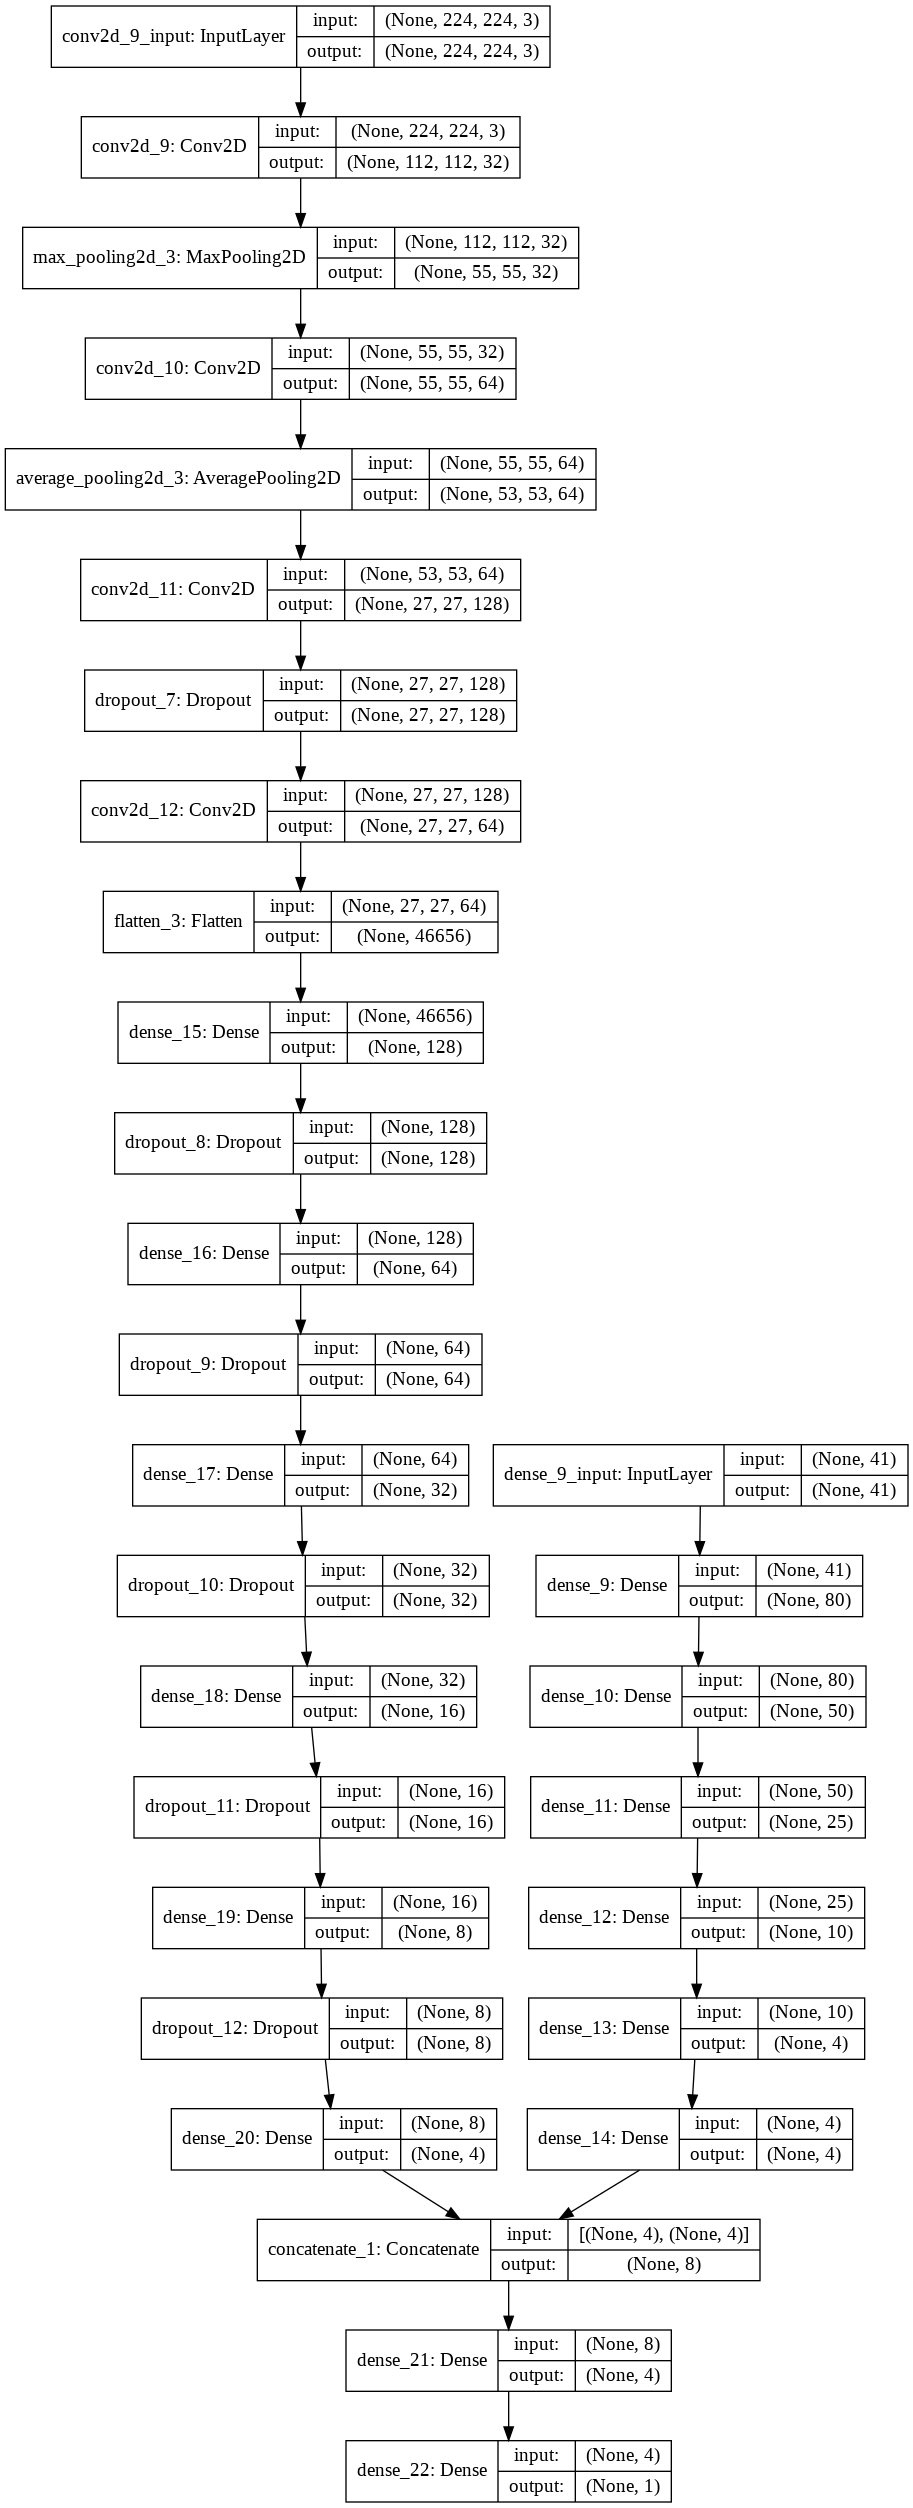

In [0]:
model.summary()
plot_model(model,show_shapes=True,to_file='model_CNNandfeature.png')

In [71]:
CNNandfeature_pred = model.predict([X_testfeatureScale, X_test])
CNNandfeature_mse = skmse(y_test, CNNandfeature_pred)
CNNandfeature_mae = skmae(y_test, CNNandfeature_pred)
CNNandfeature_r2 = skr2(y_test, CNNandfeature_pred)
print("CNN and features, MSE = ", CNNandfeature_mse)
print("CNN and features, MAE = ", CNNandfeature_mae)
print("CNN and features, R2 = ", CNNandfeature_r2)

CNN and features, MSE =  0.11759112637427989
CNN and features, MAE =  0.24799187545371346
CNN and features, R2 =  0.2173613459947802


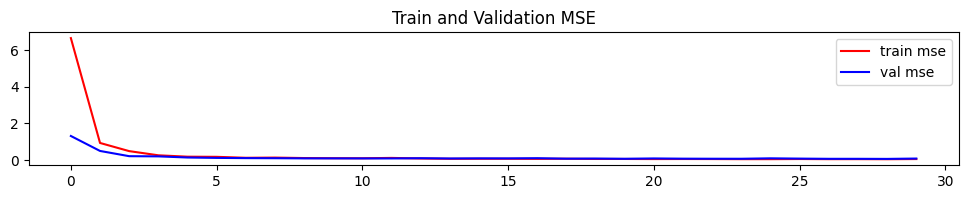

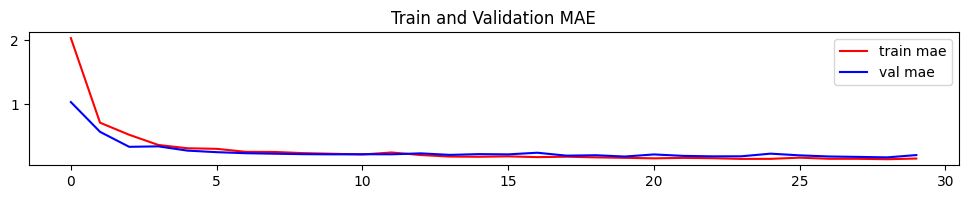

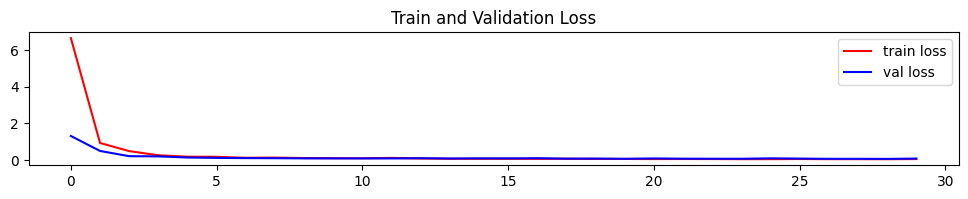

In [72]:
history_plot()

In [73]:
print("Mean: ", np.mean(CNNandfeature_pred))
print("Min: ", np.min(CNNandfeature_pred))
print("Max: ", np.max(CNNandfeature_pred))

Mean:  5.7038293
Min:  4.002799
Max:  6.415036


### 2. InceptionV3 Model

    

#### 2.1 Image alone
1.   train the new layers









In [74]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.utils import plot_model

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

model.summary()
plot_model(model,show_shapes=True,to_file='model.png')

# train the model on the new data for a few epochs
model.fit(X_train,y_train,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)


87916544/87910968 [==============================] - 2s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________________

In [75]:
IncptV3_pred = model.predict(X_test)
IncptV3_mse = skmse(y_test, IncptV3_pred)
IncptV3_mae = skmae(y_test, IncptV3_pred)
IncptV3_r2 = skr2(y_test, IncptV3_pred)
print("InceptionV3 alone, MSE = ", IncptV3_mse)
print("InceptionV3 alone, MAE = ", IncptV3_mae)
print("InceptionV3 alone, R2 = ", IncptV3_r2)

InceptionV3 alone, MSE =  0.21368374690055503
InceptionV3 alone, MAE =  0.37263497949989616
InceptionV3 alone, R2 =  -0.42219200728416006


2. train some of the inception V3 layers

In [76]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.99), loss='mse',metrics=['mse','mae'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train,y_train,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)

0 input_1
1 conv2d_21
2 batch_normalization_1
3 activation_1
4 conv2d_22
5 batch_normalization_2
6 activation_2
7 conv2d_23
8 batch_normalization_3
9 activation_3
10 max_pooling2d_6
11 conv2d_24
12 batch_normalization_4
13 activation_4
14 conv2d_25
15 batch_normalization_5
16 activation_5
17 max_pooling2d_7
18 conv2d_29
19 batch_normalization_9
20 activation_9
21 conv2d_27
22 conv2d_30
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_6
28 conv2d_26
29 conv2d_28
30 conv2d_31
31 conv2d_32
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_36
42 batch_normalization_16
43 activation_16
44 conv2d_34
45 conv2d_37
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_7
51 conv2d_33
52 conv2d_35
53 conv2d_38
54 conv2d_39
55 batch_normalization_13
56 ba

In [77]:
IncptV3_v2_pred = model.predict(X_test)
IncptV3_v2_mse = skmse(y_test, IncptV3_v2_pred)
IncptV3_v2_mae = skmae(y_test, IncptV3_v2_pred)
IncptV3_v2_r2 = skr2(y_test, IncptV3_v2_pred)
print("InceptionV3 alone, MSE = ", IncptV3_v2_mse)
print("InceptionV3 alone, MAE = ", IncptV3_v2_mae)
print("InceptionV3 alone, R2 = ", IncptV3_v2_r2)

InceptionV3 alone, MSE =  0.18052320183918866
InceptionV3 alone, MAE =  0.3096531039074988
InceptionV3 alone, R2 =  -0.2014889223396168


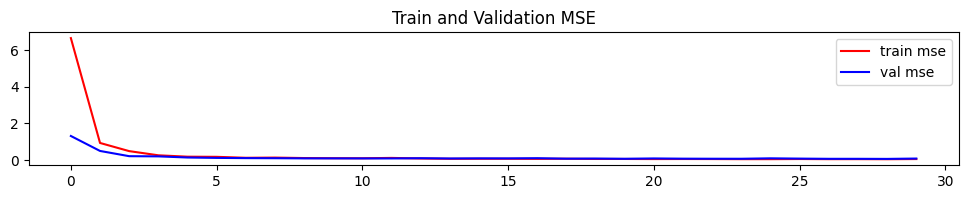

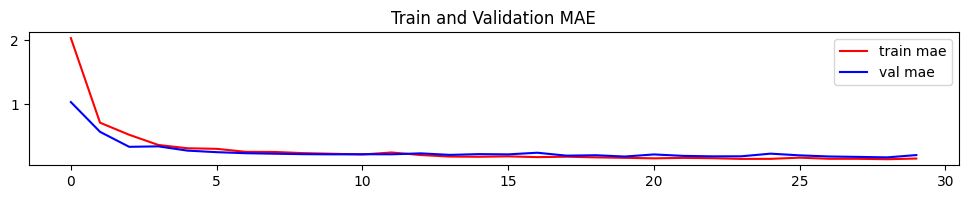

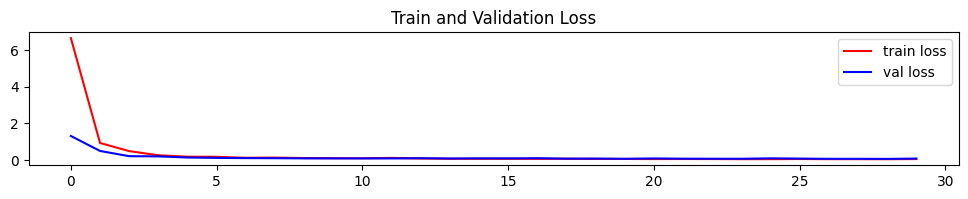

In [79]:
history_plot()

#### 2.1.2 Repeat again the 2-steps method again with y scaling:

In [89]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.utils import plot_model

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

# train the model on the new data for a few epochs
# model.fit(X_train,y_train,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)
model.fit(X_train,y_train/maxPrice,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)

IncptV3_v4_pred_scaled = model.predict(X_test)
IncptV3_v4_pred = IncptV3_v4_pred_scaled*maxPrice
IncptV3_v4_mse = skmse(y_test, IncptV3_v4_pred)
IncptV3_v4_mae = skmae(y_test, IncptV3_v4_pred)
IncptV3_v4_r2 = skr2(y_test, IncptV3_v4_pred)
print("InceptionV3 alone, MSE = ", IncptV3_v4_mse)
print("InceptionV3 alone, MAE = ", IncptV3_v4_mae)
print("InceptionV3 alone, R2 = ", IncptV3_v4_r2)

Train on 640 samples, validate on 160 samples
Epoch 1/30
10/10 [==============================] - 17s 2s/step - loss: 507.1994 - mse: 507.1993 - mae: 12.5819 - val_loss: 25.9859 - val_mse: 2598.5942 - val_mae: 159.4502
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 17.6811 - mse: 17.6811 - mae: 3.4481 - val_loss: 11.1152 - val_mse: 1111.5220 - val_mae: 103.7890
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 57.5142 - mse: 57.5142 - mae: 6.6868 - val_loss: 5.1392 - val_mse: 513.9153 - val_mae: 69.9270
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 28.9952 - mse: 28.9952 - mae: 4.3811 - val_loss: 21.9081 - val_mse: 2190.8077 - val_mae: 146.8628
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 13.3520 - mse: 13.3520 - mae: 2.7527 - val_loss: 2.8123 - val_mse: 281.2256 - val_mae: 52.0282
Epoch 6/30
10/10 [==============================] - 14s 1s/step - loss: 24.0604 - mse: 24.0604 - mae: 4.035

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.utils import plot_model

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [90]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.99), loss='mse',metrics=['mse','mae'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train,y_train,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)

# IncptV3_v5_pred = model.predict(X_test)
# IncptV3_v5_mse = skmse(y_test, IncptV3_v5_pred)
# IncptV3_v5_mae = skmae(y_test, IncptV3_v5_pred)
# IncptV3_v5_r2 = skr2(y_test, IncptV3_v5_pred)
# print("InceptionV3 alone, MSE = ", IncptV3_v5_mse)
# print("InceptionV3 alone, MAE = ", IncptV3_v5_mae)
# print("InceptionV3 alone, R2 = ", IncptV3_v5_r2)

IncptV3_v5_pred_scaled = model.predict(X_test)
IncptV3_v5_pred = IncptV3_v5_pred_scaled*maxPrice
IncptV3_v5_mse = skmse(y_test, IncptV3_v5_pred)
IncptV3_v5_mae = skmae(y_test, IncptV3_v5_pred)
IncptV3_v5_r2 = skr2(y_test, IncptV3_v5_pred)
print("InceptionV3 alone, MSE = ", IncptV3_v5_mse)
print("InceptionV3 alone, MAE = ", IncptV3_v5_mae)
print("InceptionV3 alone, R2 = ", IncptV3_v5_r2)

Train on 640 samples, validate on 160 samples
Epoch 1/30
10/10 [==============================] - 21s 2s/step - loss: 17.4105 - mse: 17.4105 - mae: 3.5608 - val_loss: 2.9165 - val_mse: 291.6477 - val_mae: 53.7451
Epoch 2/30
10/10 [==============================] - 15s 2s/step - loss: 24.4182 - mse: 24.4182 - mae: 4.5608 - val_loss: 0.0356 - val_mse: 3.5625 - val_mae: 4.3568
Epoch 3/30
10/10 [==============================] - 15s 2s/step - loss: 20.2908 - mse: 20.2908 - mae: 4.0201 - val_loss: 1.8039 - val_mse: 180.3945 - val_mae: 42.2434
Epoch 4/30
10/10 [==============================] - 15s 2s/step - loss: 11.8280 - mse: 11.8280 - mae: 2.9576 - val_loss: 3.7616 - val_mse: 376.1628 - val_mae: 61.1006
Epoch 5/30
10/10 [==============================] - 15s 2s/step - loss: 13.9717 - mse: 13.9717 - mae: 3.1764 - val_loss: 0.8889 - val_mse: 88.8903 - val_mae: 29.4838
Epoch 6/30
10/10 [==============================] - 15s 2s/step - loss: 17.6003 - mse: 17.6003 - mae: 3.9269 - val_loss: 0.

#### 2.1.3 Try to tune InceptionV3 with more layers trainable

In [91]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.utils import plot_model

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

# train the model on the new data for a few epochs
model.fit(X_train,y_train,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)

Train on 640 samples, validate on 160 samples
Epoch 1/30
10/10 [==============================] - 17s 2s/step - loss: 452.5605 - mse: 452.5604 - mae: 12.8190 - val_loss: 9.1974 - val_mse: 919.7417 - val_mae: 95.1433
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 31.7960 - mse: 31.7960 - mae: 5.3036 - val_loss: 17.4224 - val_mse: 1742.2394 - val_mae: 130.9907
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 40.2999 - mse: 40.2999 - mae: 5.9268 - val_loss: 8.2975 - val_mse: 829.7521 - val_mae: 90.0711
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 31.6138 - mse: 31.6138 - mae: 5.3044 - val_loss: 6.4706 - val_mse: 647.0577 - val_mae: 79.6452
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 17.5841 - mse: 17.5841 - mae: 3.8274 - val_loss: 7.1894 - val_mse: 718.9435 - val_mae: 84.2243
Epoch 6/30
10/10 [==============================] - 14s 1s/step - loss: 16.1260 - mse: 16.1260 - mae: 3.5863 - va

In [92]:
for layer in model.layers[:197]:
   layer.trainable = False
for layer in model.layers[197:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.00001, momentum=0.99), loss='mse',metrics=['mse','mae'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train,y_train,steps_per_epoch=10, epochs=30,validation_split = 0.2,validation_steps=10)

IncptV3_v7_pred = model.predict(X_test)
IncptV3_v7_mse = skmse(y_test, IncptV3_v7_pred)
IncptV3_v7_mae = skmae(y_test, IncptV3_v7_pred)
IncptV3_v7_r2 = skr2(y_test, IncptV3_v7_pred)
print("InceptionV3 alone, MSE = ", IncptV3_v7_mse)
print("InceptionV3 alone, MAE = ", IncptV3_v7_mae)
print("InceptionV3 alone, R2 = ", IncptV3_v7_r2)

Train on 640 samples, validate on 160 samples
Epoch 1/30
10/10 [==============================] - 26s 3s/step - loss: 1.9238 - mse: 1.9238 - mae: 1.1091 - val_loss: 0.0336 - val_mse: 3.3607 - val_mae: 4.2712
Epoch 2/30
10/10 [==============================] - 18s 2s/step - loss: 1.9979 - mse: 1.9979 - mae: 1.1236 - val_loss: 0.0306 - val_mse: 3.0560 - val_mae: 4.0176
Epoch 3/30
10/10 [==============================] - 18s 2s/step - loss: 1.7264 - mse: 1.7264 - mae: 1.0458 - val_loss: 0.0435 - val_mse: 4.3460 - val_mae: 5.9555
Epoch 4/30
10/10 [==============================] - 18s 2s/step - loss: 1.7383 - mse: 1.7383 - mae: 1.0504 - val_loss: 0.0252 - val_mse: 2.5242 - val_mae: 3.5431
Epoch 5/30
10/10 [==============================] - 18s 2s/step - loss: 1.7187 - mse: 1.7187 - mae: 1.0428 - val_loss: 0.0288 - val_mse: 2.8792 - val_mae: 3.8802
Epoch 6/30
10/10 [==============================] - 18s 2s/step - loss: 1.5843 - mse: 1.5843 - mae: 1.0000 - val_loss: 0.0369 - val_mse: 3.6927 

### 2.2. InceptionV3 to concatenate with other features

2.2.1 Prepare inceptionV3 layers for concatenation

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Reshape, Input, InputLayer
from keras import backend as K

In [0]:
# InceptionV3 model function

# create the base pre-trained model
def buildinceptionv3(regress=False):
  base_model = InceptionV3(weights='imagenet', include_top=False)

  # add a global spatial average pooling layer
  x = base_model.output
  x = Dropout(.5)(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(.5)(x)
  # let's add a fully-connected layer
  x = Dense(1024, activation='selu')(x)
  x = Dropout(.0625)(x)
  # predictions = Dense(4)(x)
  # x = Dense(4, activation='selu')(x)
  # x = Dropout(.03125)(x)
  # and output layer
  predictions = Dense(1)(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
    layer.trainable = False

  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

  # train the model on the new data for a few epochs
  model.fit(X_train,y_train,steps_per_epoch=10, epochs=10,validation_split = 0.2,validation_steps=10)

  # at this point, the top layers are well trained and we can start fine-tuning
  # convolutional layers from inception V3. We will freeze the bottom N layers
  # and train the remaining top layers.

  # we chose to train the top 2 inception blocks, i.e. we will freeze
  # the first 249 layers and unfreeze the rest:
  for layer in model.layers[:249]:
    layer.trainable = False
  for layer in model.layers[249:]:
    layer.trainable = True

  return model

In [0]:
def create_mlp(dim, regress=False):# define our MLP network
  model = Sequential()
  model.add(Dense(80, input_dim=dim, activation="relu"))
  model.add(Dense(50, activation = 'relu'))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(10, activation="relu"))
  model.add(Dense(4, activation="linear"))
  model.add(Dense(4, activation="linear"))

	# check to see if the regression node should be added
  if regress:
    model.add(Dense(1, activation="linear"))

	# return our model
  return model

2.2.2 Run concatenated model - Optimizer as optimized Adam

In [102]:
# Use Adam as optimizer
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
trainImagesX, testImagesX, trainy, testy = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
# using scaled features
trainAttrX, testAttrX, trainy, testy = train_test_split(X_trainfeatureScale, y_train, test_size=0.20, random_state=42)

# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
incv3 = buildinceptionv3(regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and InceptionV3
combinedInput = concatenate([mlp.output, incv3.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="selu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the InceptionV3 input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, incv3.input], outputs=x)

# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
# model.compile(optimizer=opt, loss='mse', metrics=['mse','mae'])

from keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='adam', loss='mse',metrics=['mse','mae'])
# train the model
print("[INFO] training model...")
history = model.fit([trainAttrX, trainImagesX], trainy,steps_per_epoch=10,validation_data=([testAttrX, testImagesX], testy), epochs=30,validation_steps=10)

# history = model.fit([trainAttrX, trainImagesX],y_train, verbose=1, steps_per_epoch=30, epochs=30,validation_split = 0.2,validation_steps=30)


[INFO] processing data...
Train on 640 samples, validate on 160 samples
Epoch 1/10
10/10 [==============================] - 17s 2s/step - loss: 463.9506 - mse: 463.9506 - mae: 12.6103 - val_loss: 8.8034 - val_mse: 880.3398 - val_mae: 93.1161
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 28.3486 - mse: 28.3486 - mae: 5.1234 - val_loss: 16.2511 - val_mse: 1625.1135 - val_mae: 126.5099
Epoch 3/10
10/10 [==============================] - 14s 1s/step - loss: 38.3690 - mse: 38.3690 - mae: 5.8717 - val_loss: 7.5714 - val_mse: 757.1441 - val_mae: 86.0425
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 30.2396 - mse: 30.2396 - mae: 5.3345 - val_loss: 6.1805 - val_mse: 618.0511 - val_mae: 77.9356
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 14.6647 - mse: 14.6647 - mae: 3.6688 - val_loss: 8.4150 - val_mse: 841.5038 - val_mae: 91.3169
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 11.9697 - mse: 

Plot validation metrics

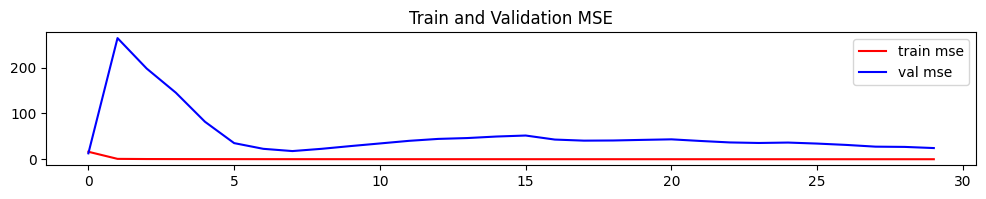

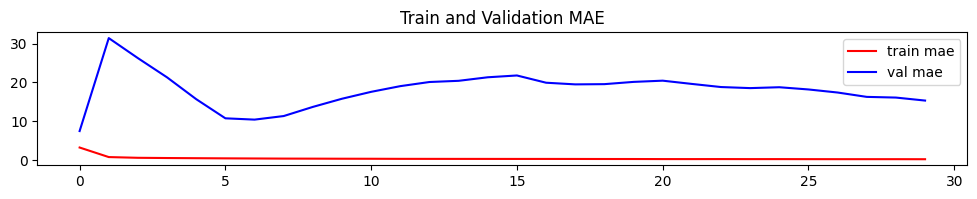

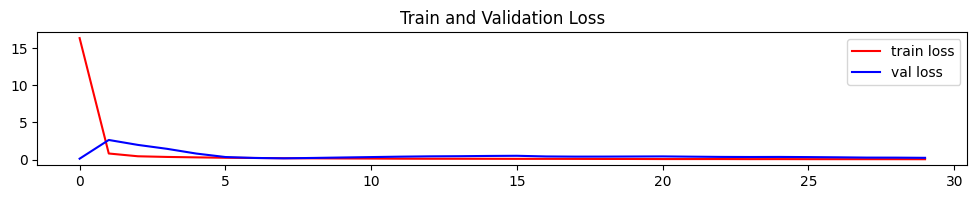

In [105]:
history_plot()

In [106]:
IncptV3andfeature_pred = model.predict([X_testfeatureScale, X_test])
IncptV3andfeature_mse = skmse(y_test, IncptV3andfeature_pred)
IncptV3andfeature_mae = skmae(y_test, IncptV3andfeature_pred)
IncptV3andfeature_r2 = skr2(y_test, IncptV3andfeature_pred)
print("InceptionV3 alone, MSE = ", IncptV3andfeature_mse)
print("InceptionV3 alone, MAE = ", IncptV3andfeature_mae)
print("InceptionV3 alone, R2 = ", IncptV3andfeature_r2)

InceptionV3 alone, MSE =  2.5633491760250955
InceptionV3 alone, MAE =  1.5635305843901892
InceptionV3 alone, R2 =  -16.06060831906846


In [116]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_14
1 conv2d_1243
2 batch_normalization_1223
3 activation_1223
4 conv2d_1244
5 batch_normalization_1224
6 activation_1224
7 conv2d_1245
8 batch_normalization_1225
9 activation_1225
10 max_pooling2d_58
11 conv2d_1246
12 batch_normalization_1226
13 activation_1226
14 conv2d_1247
15 batch_normalization_1227
16 activation_1227
17 max_pooling2d_59
18 conv2d_1251
19 batch_normalization_1231
20 activation_1231
21 conv2d_1249
22 conv2d_1252
23 batch_normalization_1229
24 batch_normalization_1232
25 activation_1229
26 activation_1232
27 average_pooling2d_123
28 conv2d_1248
29 conv2d_1250
30 conv2d_1253
31 conv2d_1254
32 batch_normalization_1228
33 batch_normalization_1230
34 batch_normalization_1233
35 batch_normalization_1234
36 activation_1228
37 activation_1230
38 activation_1233
39 activation_1234
40 mixed0
41 conv2d_1258
42 batch_normalization_1238
43 activation_1238
44 conv2d_1256
45 conv2d_1259
46 batch_normalization_1236
47 batch_normalization_1239
48 activation_1236
49 activatio

### 3. Visualize the predicted price vs actual price
3.1 Custome CNN

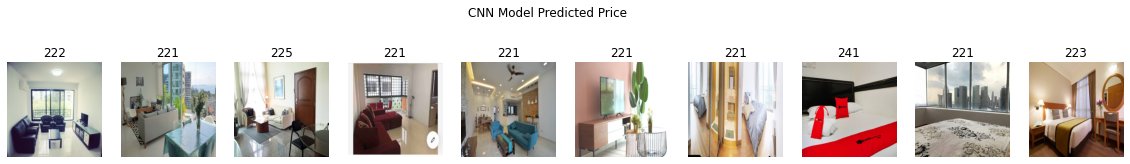

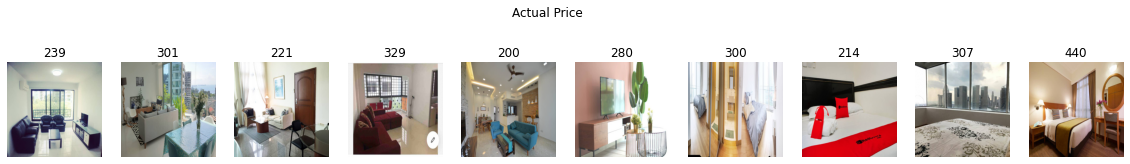

In [113]:
plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(CNN_pred[n][0])))
  plt.axis('off')
_ = plt.suptitle("CNN Model Predicted Price")

plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(y_test[n])))
  plt.axis('off')
_ = plt.suptitle("Actual Price")

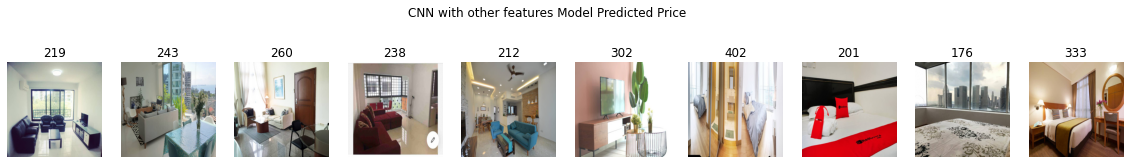

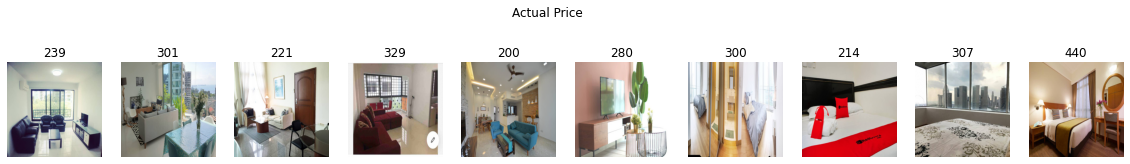

In [40]:
plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(CNNandfeature_pred[n][0])))
  plt.axis('off')
_ = plt.suptitle("CNN with other features Model Predicted Price")

plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(y_test[n])))
  plt.axis('off')
_ = plt.suptitle("Actual Price")

3.2 Inception V3

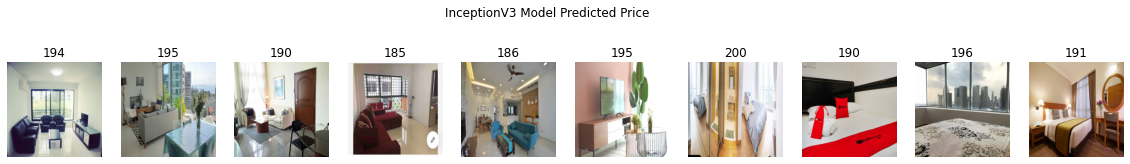

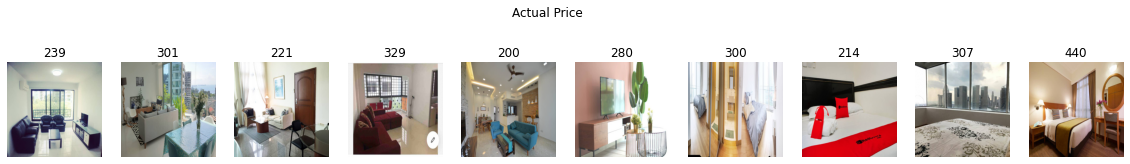

In [111]:
plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(IncptV3_pred[n][0])))
  plt.axis('off')
_ = plt.suptitle("InceptionV3 Model Predicted Price")

plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(y_test[n])))
  plt.axis('off')
_ = plt.suptitle("Actual Price")

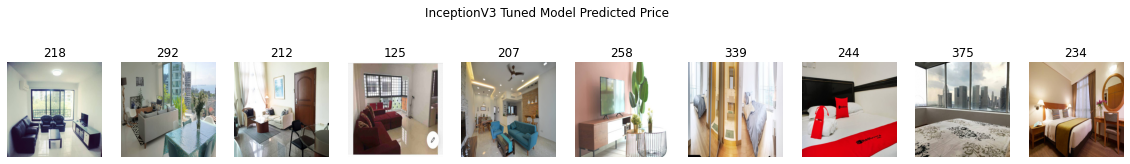

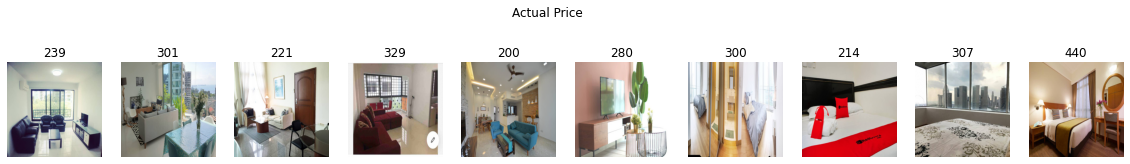

In [112]:
plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(IncptV3_v2_pred[n][0])))
  plt.axis('off')
_ = plt.suptitle("InceptionV3 Tuned Model Predicted Price")

plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(int(math.exp(y_test[n])))
  plt.axis('off')
_ = plt.suptitle("Actual Price")

**Conclution**: Relying on image model alone to predict the price of an Airbnb listing is not realistic due to there's only one main image considered. However, it could be useful for this model to decide what picture to put first for a listing to maximize the listing price. 

In [0]:
'''def build_autoencoder(img_shape=(None,8)):
    # The encoder
    encoder = InceptionV3(weights='imagenet', include_top=False)
    encoder.layers.pop()
    encoder.layers.pop()
    encoder.summary()
    encoder = Dense(img_shape,activation = 'selu')(encoder)

    # The decoder
    decoder = Sequential()
    decoder = Dense(img_shape,activation = 'selu')(encoder)
    return encoder, decoder'''
    
'''encoder, decoder = build_autoencoder()

inp = (None,8)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['mse','mae'])'''

### Backups: Prediction of price without log tranformation

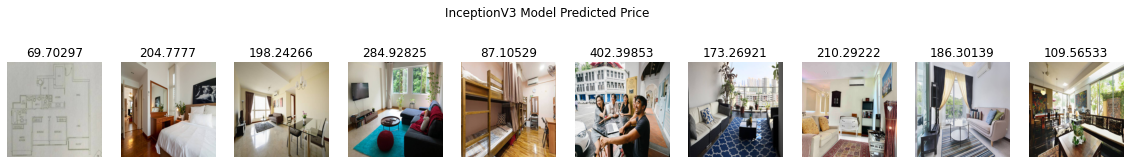

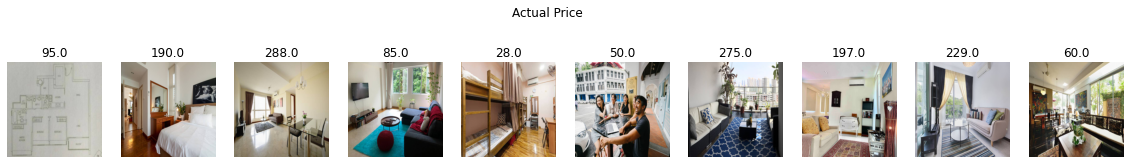

In [0]:
plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(pred[n][0])
  plt.axis('off')
_ = plt.suptitle("InceptionV3 Model Predicted Price")

plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n])
  plt.title(y_test[n])
  plt.axis('off')
_ = plt.suptitle("Actual Price")

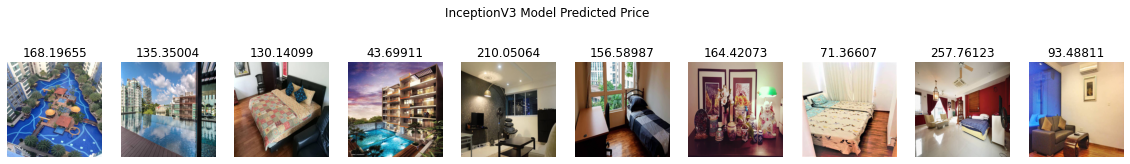

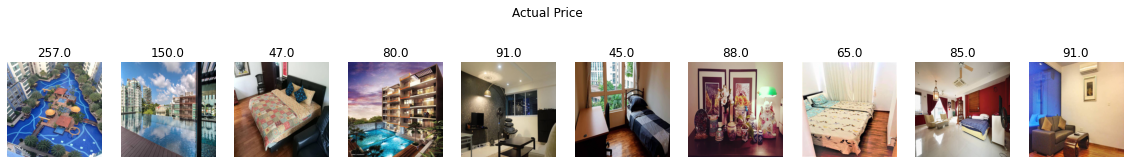

In [0]:
plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n+10])
  plt.title(pred[n+10][0])
  plt.axis('off')
_ = plt.suptitle("InceptionV3 Model Predicted Price")

plt.figure(figsize=(20,3))
for n in range(10):
  plt.subplot(1,10,n+1)
  plt.imshow(X_test[n+10])
  plt.title(y_test[n+10])
  plt.axis('off')
_ = plt.suptitle("Actual Price")